<a href="https://colab.research.google.com/github/cadenzonnefeld/PaintingsGAN/blob/main/PaintingsGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I'm Something of a Painter Myself
The focus of this project for Module 5 of the course is to complete [this](https://www.kaggle.com/competitions/gan-getting-started/data) Kaggle competition.

\\
The competition focuses on using Generative Adversarial Networks (GANs) to reproduce artwork. In particular, the goal is to train a model on a sample of 300 Monet paintings and reconstruct the photos provided to take on a Monet style. A GAN model will be trained on the data to learn the stylistic choices made by Monet and be able to reconstruct Monet-like works of art as a result.

\\
To accomplish this aim, we are provided with 7028 images which we will Monet-ify and 300 Monety paintings which which to train the model upon. Each image is 256x256x3 in dimension, that is, 256x256 pixels with RGB channels of color.

### Package Import & Dataset Download from Kaggle

In [182]:
import os
import tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, LeakyReLU, Reshape, Conv2DTranspose, Input
from PIL import Image
from google.colab import drive, files

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Establishing a connection key and process to kaggle.

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"cadenzonefeld","key":"d0a0fadb8d1e4ba8c191b6e6e913f4b5"}'}

In [4]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pwd

-rw-r--r-- 1 root root 69 Oct 17 20:20 kaggle.json
/content


In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset          Customer Shopping Trends Dataset                  146KB  2023-10-05 06:45:37           5832        136  1.0              
nelgiriyewithana/top-spotify-songs-2023                     Most Streamed Spotify Songs 2023                   47KB  2023-08-26 11:04:57          33346       1002  1.0              
nelgiriyewithana/credit-card-fraud-detection-dataset-2023   Credit Card Fraud Detection Dataset 2023          143MB  2023-09-18 10:00:19           5916        197  1.0              
nelgiriyewithana/billionaires-statistics-dataset            Billionaires Statistics Datase

Downloading the dataset from kaggle as a .zip file and unzipping the photos.

In [7]:
!kaggle competitions download -c gan-getting-started

gan-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!unzip gan-getting-started

Archive:  gan-getting-started.zip
replace monet_jpg/000c1e3bff.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Exporing the structure of the directory to allow us to access the image files.

In [9]:
os.listdir()

['.config',
 'photo_jpg',
 'gan-getting-started.zip',
 'photo_tfrec',
 'monet_jpg',
 'kaggle (1).json',
 'drive',
 'kaggle.json',
 'monet_tfrec',
 'sample_data']

In [10]:
photo_dir = "/content/photo_jpg"
monet_dir = "/content/monet_jpg"

In [11]:
os.listdir(photo_dir)[:15]

['96cda40153.jpg',
 '95900a984f.jpg',
 'b9973b92ba.jpg',
 '63e73c1dc9.jpg',
 'd62eeaccb0.jpg',
 'ded7482c2c.jpg',
 '29c0dfdae4.jpg',
 '3be1aea5fc.jpg',
 '4cdd74b1c7.jpg',
 '327bbda45b.jpg',
 '8ebecab630.jpg',
 'e0839b3c2e.jpg',
 '3c53ee8af8.jpg',
 'a85633910c.jpg',
 '6efbef83a2.jpg']

Creating a dataframe for photos and Monet paintings that has a 'path' column that leads to the images and a 'class' column that labels the image as either a "photo" or a "monet".

In [108]:
photo_paths = [photo_dir + "/" + pic for pic in os.listdir(photo_dir)]
photo_df = pd.DataFrame({"path":photo_paths, "class":'photo'})

monet_paths = [monet_dir + "/" + pic for pic in os.listdir(monet_dir)]
monet_df = pd.DataFrame({"path":monet_paths, "class":'monet'})

Creating data generators for the photos and monets. The ImageDataGenerator() allows for new images to be loaded for each batch as the model is loaded and provides greater efficiency and a reduction in memory load strain.

In [109]:
datagenerator = ImageDataGenerator(rescale=1./255)

photo_gen = datagenerator.flow_from_dataframe(
    dataframe=photo_df,
    x_col='path',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
)

monet_gen = datagenerator.flow_from_dataframe(
    dataframe=monet_df,
    x_col='path',
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
)

Found 7038 validated image filenames belonging to 1 classes.
Found 300 validated image filenames belonging to 1 classes.


### Exploratory Data Analysis

Since the data consists of images there are fewer standard EDA techniques available (i.e. mean, median, boxplot, visualizations, etc.) so we will examine a few images from the Monets dataset and the photos dataset.

Displaying several example Monets. The Monets depict the style characteristic to Claude Monet himself and have clear indications of being produced by painting.

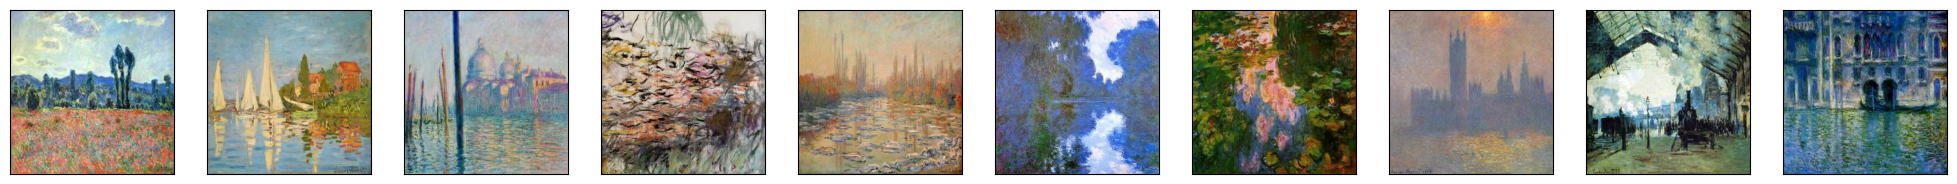

In [110]:
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open(monet_df.iloc[i, 0])
    plt.imshow(im)

Displaying several example photos. This sampling of photos consists of nature shots in variety of different ecosystems.

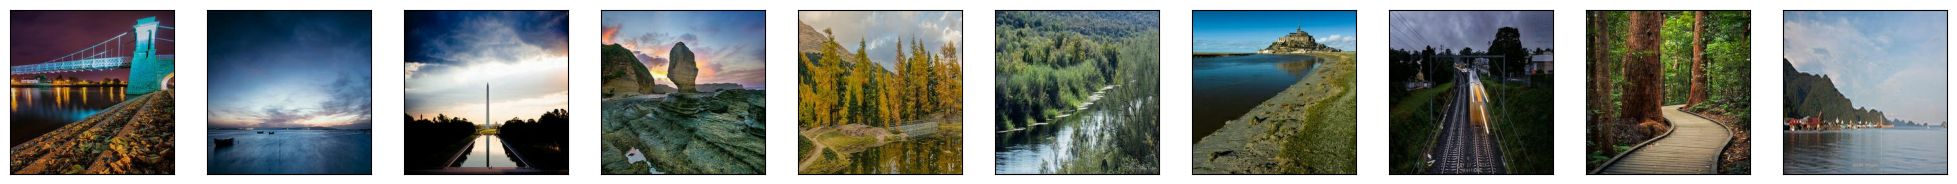

In [111]:
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open(photo_df.iloc[i, 0])
    plt.imshow(im)

### Model Architecture

Creating a discriminator function for the GAN.

In [131]:
def discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (3,3), strides = (2, 2), padding = 'same', input_shape = (256, 256, 3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))
    discriminator.add(Conv2D(128, (3,3), strides = (2, 2), padding = 'same'))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(Dropout(0.4))
    discriminator.add(Conv2D(128, (3,3), strides = (2, 2), padding = 'same'))
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense(1, activation = 'sigmoid'))

    return discriminator

In [132]:
photos_discriminator = discriminator()
monet_discriminator = discriminator()

In [134]:
photos_discriminator.summary()
monet_discriminator.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 dropout_39 (Dropout)        (None, 128, 128, 64)      0         
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 dropout_40 (Dropout)        (None, 64, 64, 128)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 128)     

Creating a generator function for the GAN.

In [181]:
def generator():
    generator = Sequential()
    generator.add(Input(shape=(256, 256, 3)))
    generator.add(Dense(128 * 16 * 16, activation = 'relu', input_dim = 1000))
    generator.add(Reshape((16, 16, 128)))
    generator.add(Conv2DTranspose(128, (3,3)))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2DTranspose(256, (3,3)))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2DTranspose(512, (3,3)))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(Conv2D(3, (3,3), activation='sigmoid'))

    return generator


In [173]:
photos_generator = generator()
monet_generator = generator()

In [174]:
photos_generator.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 32768)             32800768  
                                                                 
 reshape_21 (Reshape)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_64 (Conv2  (None, 18, 18, 128)       147584    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_96 (LeakyReLU)  (None, 18, 18, 128)       0         
                                                                 
 conv2d_transpose_65 (Conv2  (None, 20, 20, 256)       295168    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_97 (LeakyReLU)  (None, 20, 20, 256)     

In [175]:
noise = tensorflow.random.normal([1, 1000])
generated_image = photos_generator(noise)

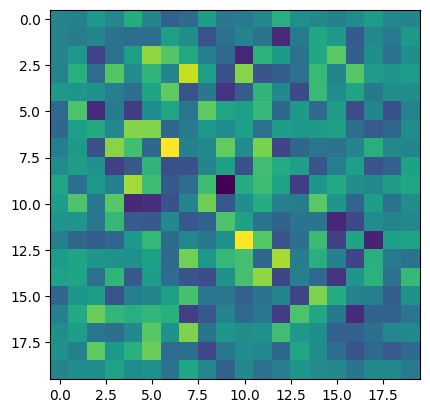

In [176]:
plt.imshow(generated_image[0, :, :, 0])

In [74]:
print(decision)

tf.Tensor([[0.5037235]], shape=(1, 1), dtype=float32)


In [120]:
monet_generator.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 32768)             3309568   
                                                                 
 reshape_8 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_24 (Conv2  (None, 18, 18, 128)       147584    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 18, 18, 128)       0         
                                                                 
 conv2d_transpose_25 (Conv2  (None, 20, 20, 256)       295168    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 20, 20, 256)     

Creating the loss functions and optimizers for each to set up for the train step.

In [179]:
cross_entropy = tensorflow.keras.losses.BinaryCrossentropy(from_logits=True)

In [180]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tensorflow.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tensorflow.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tensorflow.ones_like(fake_output), fake_output)


In [178]:
photos_generator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)
photos_discriminator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)
monet_generator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)
monet_discriminator_optimizer = tensorflow.keras.optimizers.Adam(1e-4)

Ran out of time to finish the project before the deadline; would have added a train step to train the GAN and then generated photos to submit to the kaggle competition.